In [5]:
import sys, os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from art.utils import load_mnist
import numpy as np
import pandas as pd
from random import choice, randint
import tensorflow as tf

In [2]:
aid = pd.read_csv('../checkpoint_adult/adult.csv')
df = pd.read_csv('../checkpoint_adult/adult.csv')

In [3]:
aid = aid.drop('education',axis=1)
aid = pd.concat([aid.drop('workclass',axis=1),pd.get_dummies(aid.workclass).add_prefix('workclass_')],axis=1)
aid = pd.concat([aid.drop('occupation',axis=1),pd.get_dummies(aid.occupation).add_prefix('occupation_')],axis=1)
aid = pd.concat([aid.drop('marital-status',axis=1),pd.get_dummies(aid['marital-status']).add_prefix('marital-status_')],axis=1)
aid = pd.concat([aid.drop('relationship',axis=1),pd.get_dummies(aid.relationship).add_prefix('relationship_')],axis=1)
aid = pd.concat([aid.drop('native-country',axis=1),pd.get_dummies(aid['native-country']).add_prefix('native-country_')],axis=1)
aid = pd.concat([aid.drop('race',axis=1),pd.get_dummies(aid.race).add_prefix('race_')],axis=1)

In [4]:
from sklearn import preprocessing
label_encoder=preprocessing.LabelEncoder()
df['gender'] = label_encoder.fit_transform(df['gender'])
df['workclass'] = label_encoder.fit_transform(df['workclass'])
df['education'] = label_encoder.fit_transform(df['education'])
df['marital-status'] = label_encoder.fit_transform(df['marital-status'])
df['occupation'] = label_encoder.fit_transform(df['occupation'])
df['relationship'] = label_encoder.fit_transform(df['relationship'])
df['race'] = label_encoder.fit_transform(df['race'])
df['native-country'] = label_encoder.fit_transform(df['native-country'])
df['income'] = label_encoder.fit_transform(df['income'])

In [5]:
aid['gender']=aid['gender'].apply(lambda x: 1 if x == 'Male' else 0)
aid['income']=aid['income'].apply(lambda x: 1 if  x == '>50K'else 0)

In [6]:
train_aid , test_aid =  train_test_split(df,test_size=0.2)


# verification of train_test_split
assert len(aid) == len(train_aid) + len(test_aid)

train_X = train_aid.drop('income',axis=1)
train_y = train_aid['income']

test_X = train_aid.drop('income',axis=1)
test_y = train_aid['income']

forest = RandomForestClassifier(max_depth=5)

forest.fit(train_X,train_y)

forest.score(test_X,test_y)

0.850459396514217

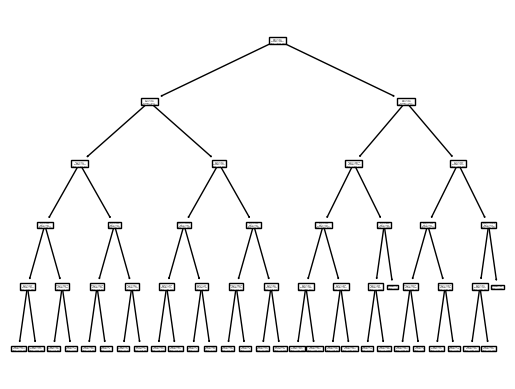

In [20]:
from sklearn import tree
from matplotlib import pyplot as plt

t = forest.estimators_[0]
tree.plot_tree(t)
plt.show()

In [44]:
from sklearn.preprocessing import MinMaxScaler

minmaxscale = MinMaxScaler()
toScale = np.asarray(train_aid)
scaled = minmaxscale.fit_transform(train_aid)
#df = pd.DataFrame(scaled, columns=train_X.columns)
scaled

array([[0.08219178, 0.5       , 0.1309641 , ..., 0.60204082, 0.95121951,
        0.        ],
       [0.36986301, 0.5       , 0.06218122, ..., 0.44897959, 0.95121951,
        1.        ],
       [0.16438356, 0.5       , 0.15502583, ..., 0.39795918, 0.95121951,
        1.        ],
       ...,
       [0.49315068, 0.75      , 0.18404793, ..., 0.5       , 0.95121951,
        1.        ],
       [0.21917808, 0.5       , 0.26094722, ..., 0.39795918, 0.95121951,
        0.        ],
       [0.04109589, 0.        , 0.07376151, ..., 0.39795918, 0.95121951,
        0.        ]])

In [14]:
help(MinMaxScaler.fit_transform)

Help on function fit_transform in module sklearn.base:

fit_transform(self, X, y=None, **fit_params)
    Fit to data, then transform it.
    
    Fits transformer to `X` and `y` with optional parameters `fit_params`
    and returns a transformed version of `X`.
    
    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        Input samples.
    
    y :  array-like of shape (n_samples,) or (n_samples, n_outputs),                 default=None
        Target values (None for unsupervised transformations).
    
    **fit_params : dict
        Additional fit parameters.
    
    Returns
    -------
    X_new : ndarray array of shape (n_samples, n_features_new)
        Transformed array.



In [19]:
import math
def mean(myarray):
    mn = np.mean(myarray)
    return 0 if math.isnan(mn) else mn

def fairness(model, x_test, y_test, group_test, forest_model=True, true_y_test=[]):
    yhat = np.round(model.predict(x_test))
    if forest_model:
        acc = model.score(x_test, y_test)
    else:
        acc = model.evaluate(x_test, y_test)[1]
    
    p_grp_tpr = mean(yhat[(y_test == 1) & (group_test == 1)])
    up_grp_tpr = mean(yhat[(y_test == 1) & (group_test == 0)])
    
    # equality of difference (opportinuty)
    eod = float(format(abs(p_grp_tpr - up_grp_tpr), ".4f"))

    # statistical parity difference
    p_grp = mean(yhat[(group_test == 1)])
    up_grp = mean(yhat[(group_test == 0)])
    spd = float(format(abs(p_grp - up_grp), ".4f"))
    return {"EOD": eod, "SPD": spd, "ACC": acc}

In [8]:
def train_testfairness_randomforest(train_aid, maxdepth=50):
    Y = train_aid['income']
    X = train_aid.drop('income',axis=1)
    S = train_aid['gender']

    x_train, x_test, y_train, y_test, s_train, s_test = train_test_split(
        X, Y, S, test_size=0.2, random_state=0
    )
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_test, y_test = np.asarray(x_test), np.asarray(y_test)
    s_train, s_test = np.asarray(s_train), np.asarray(s_test)
    
    forest = RandomForestClassifier(max_depth=maxdepth)

    forest.fit(x_train,y_train)
    return fairness(forest, x_test, y_test, s_test), forest

def train_testfairness_sequantial(train_aid):
    Y = train_aid['income']
    X = train_aid.drop('income',axis=1)
    S = train_aid['gender']

    x_train, x_test, y_train, y_test, s_train, s_test = train_test_split(
        X, Y, S, test_size=0.2, random_state=0
    )
    x_train, y_train = np.array(x_train), np.array(y_train)
    x_test, y_test = np.asarray(x_test), np.asarray(y_test)
    s_train, s_test = np.asarray(s_train), np.asarray(s_test)
    
    
    model = tf.keras.models.Sequential([tf.keras.Input(x_train.shape[1:])])
    model.add(tf.keras.layers.Dense(16, activation="relu"))
    model.add(tf.keras.layers.Dense(32, activation="relu"))
    model.add(tf.keras.layers.Dense(64, activation="relu"))
    model.add(tf.keras.layers.Dense(128, activation="relu"))
    model.add(tf.keras.layers.Dense(64, activation="relu"))
    model.add(tf.keras.layers.Dense(32, activation="relu"))
    model.add(tf.keras.layers.Dense(16, activation="relu"))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy"), tf.keras.metrics.Recall(name="recall")])

    model.fit(x_train,y_train, epochs=100, verbose=False)
    return fairness(model, x_test, y_test, s_test, forest_model=False), model

metric_s1 , model_s1 = train_testfairness_randomforest(train_aid)
metric_s1

{'EOD': 0.0963, 'SPD': 0.1769, 'ACC': 0.853358925143954}

In [9]:
# creating fairmodels
def new_dataset(adult, alpha = [50, 50]):
    group = "gender"
    target = "income"
    p_grp_pr = adult[(adult[group] == 1) & (adult[target] == 1)]
    up_grp_pr = adult[(adult[group] == 0) & (adult[target] == 1)]
    rest_of_df = adult[((adult[group] != 1) & (adult[group] != 0)) | (adult[target] == 0)]
    p_vs_up = pd.concat([p_grp_pr, up_grp_pr])
    
    dist = np.random.dirichlet(alpha, 1)
    size_p_grp = int(dist[0][0]*p_vs_up.shape[0])
    size_up_grp = p_vs_up.shape[0]-size_p_grp
    
    p_grp = p_grp_pr.sample(size_p_grp, replace=True)
    up_grp = up_grp_pr.sample(size_up_grp, replace=True)
    final_df = pd.concat([p_grp, up_grp, rest_of_df])
    
    return final_df

tt = train_aid
final_df = new_dataset(train_aid, alpha=[200,100])
metric1 , model1 = train_testfairness_randomforest(final_df, maxdepth=50)
metric1

{'EOD': 0.1626, 'SPD': 0.0261, 'ACC': 0.9138835572616762}

In [10]:
final_df = new_dataset(train_aid, alpha=[200,10])
metric2 , model2 = train_testfairness_randomforest(final_df, maxdepth=20)
metric2, model2.max_depth

({'EOD': 0.3784, 'SPD': 0.305, 'ACC': 0.9062060140754958}, 20)

In [11]:
class AdultTeacher():
    def __init__(self, model, metrics):
        self.metrics = metrics
        self.model = model

In [12]:
import pickle
df = pd.read_csv('../checkpoint_adult/adult.csv')

label_encoder=preprocessing.LabelEncoder()
df['gender'] = label_encoder.fit_transform(df['gender'])
df['workclass'] = label_encoder.fit_transform(df['workclass'])
df['education'] = label_encoder.fit_transform(df['education'])
df['marital-status'] = label_encoder.fit_transform(df['marital-status'])
df['occupation'] = label_encoder.fit_transform(df['occupation'])
df['relationship'] = label_encoder.fit_transform(df['relationship'])
df['race'] = label_encoder.fit_transform(df['race'])
df['native-country'] = label_encoder.fit_transform(df['native-country'])
df['income'] = label_encoder.fit_transform(df['income'])
aid['gender']=aid['gender'].apply(lambda x: 1 if x == 'Male' else 0)
aid['income']=aid['income'].apply(lambda x: 1 if  x == '>50K'else 0)

train_aid , test_aid =  train_test_split(df,test_size=0.2)

with open("../checkpoint_adult/st_dataset.pkl", "wb") as f:
    pickle.dump(test_aid, f, pickle.HIGHEST_PROTOCOL)

In [96]:
def creating_fair_pool(ori_dataset, pool_size=15, metric="EOD", verbose=False):
    if metric == "EOD":
        alpha = [200, 50]
    else:
        alpha = [200, 100]
    teachers = []
    path = f"../checkpoint_adult/{metric}/fairs/"
    depth = 10
    previous=False
    while pool_size > 0:
        dataset = new_dataset(ori_dataset, alpha=alpha)
        metrics , model = train_testfairness_randomforest(final_df, maxdepth=depth)
        if metrics[metric] > 0.1:
            if verbose and not previous:
                print("Not yet :(")
                previous = True
            continue
        else:
            previous = False
        tchr = AdultTeacher(model, metrics)
        teachers.append(tchr)
        pool_size-=1
        if verbose:
            print(f"Fair - {metric} - state : ", pool_size)
        if pool_size % 3 == 0:
            depth += 10
    with open(path + "models.pkl", "wb") as f:
        pickle.dump(teachers, f, pickle.HIGHEST_PROTOCOL)
    return teachers

def creating_unfair_pool(ori_dataset, pool_size=15, metric="EOD", verbose=False):
    if metric == "EOD":
        alpha = [100, 100]
    else:
        alpha = [200, 10]
    teachers = []
    path = f"../checkpoint_adult/{metric}/unfairs/"
    depth = 10
    previous = False
    while pool_size > 0:
        dataset = new_dataset(ori_dataset, alpha=alpha)
        metrics , model = train_testfairness_randomforest(final_df, maxdepth=depth)
        if metrics[metric] < 0.1:
            if verbose and not previous:
                print("Not yet :(")
                previous = True
            continue
        else:
            previous = False
        tchr = AdultTeacher(model, metrics)
        teachers.append(tchr)
        pool_size-=1
        if pool_size%3 == 0:
            depth+=10
        if verbose:
            print(f"Unfair - {metric} - state : ", pool_size)
    with open(path + "models.pkl", "wb") as f:
        pickle.dump(teachers, f, pickle.HIGHEST_PROTOCOL)
    return teachers

In [62]:
r = creating_fair_pool(train_aid, metric="EOD", verbose=True)

Fair - EOD - state :  14
Fair - EOD - state :  13
Fair - EOD - state :  12
Fair - EOD - state :  11
Fair - EOD - state :  10
Fair - EOD - state :  9
Fair - EOD - state :  8
Fair - EOD - state :  7
Fair - EOD - state :  6
Fair - EOD - state :  5
Fair - EOD - state :  4
Fair - EOD - state :  3
Fair - EOD - state :  2
Fair - EOD - state :  1
Fair - EOD - state :  0


In [91]:
r = creating_fair_pool(train_aid, metric="SPD", verbose=True)

Fair - SPD - state :  14
Fair - SPD - state :  13
Fair - SPD - state :  12
Fair - SPD - state :  11
Fair - SPD - state :  10
Fair - SPD - state :  9
Fair - SPD - state :  8
Fair - SPD - state :  7
Fair - SPD - state :  6
Fair - SPD - state :  5
Fair - SPD - state :  4
Fair - SPD - state :  3
Fair - SPD - state :  2
Fair - SPD - state :  1
Fair - SPD - state :  0


In [94]:
r = creating_unfair_pool(train_aid, metric="EOD", verbose=True)

Unfair - EOD - state :  14
Unfair - EOD - state :  13
Unfair - EOD - state :  12
Unfair - EOD - state :  11
Unfair - EOD - state :  10
Unfair - EOD - state :  9
Unfair - EOD - state :  8
Unfair - EOD - state :  7
Unfair - EOD - state :  6
Unfair - EOD - state :  5
Unfair - EOD - state :  4
Unfair - EOD - state :  3
Unfair - EOD - state :  2
Unfair - EOD - state :  1
Unfair - EOD - state :  0


In [100]:
r = creating_unfair_pool(train_aid, metric="SPD", verbose=True)

Unfair - SPD - state :  14
Unfair - SPD - state :  13
Unfair - SPD - state :  12
Unfair - SPD - state :  11
Unfair - SPD - state :  10
Unfair - SPD - state :  9
Unfair - SPD - state :  8
Unfair - SPD - state :  7
Unfair - SPD - state :  6
Unfair - SPD - state :  5
Unfair - SPD - state :  4
Unfair - SPD - state :  3
Unfair - SPD - state :  2
Unfair - SPD - state :  1
Unfair - SPD - state :  0


In [13]:
metric= "SPD"
path = f"../checkpoint_adult/{metric}/fairs/models.pkl"
with open(path, "rb") as f:
    teachers = pickle.load(f)
for tchr in teachers:
    print(tchr.metrics)

{'EOD': 0.2882, 'SPD': 0.0217, 'ACC': 0.887410440122825}
{'EOD': 0.2718, 'SPD': 0.0119, 'ACC': 0.8904810644831116}
{'EOD': 0.2569, 'SPD': 0.0071, 'ACC': 0.8879222108495394}
{'EOD': 0.2555, 'SPD': 0.0035, 'ACC': 0.9186284544524054}
{'EOD': 0.2347, 'SPD': 0.012, 'ACC': 0.9160696008188332}
{'EOD': 0.2293, 'SPD': 0.0132, 'ACC': 0.920675537359263}
{'EOD': 0.2227, 'SPD': 0.0094, 'ACC': 0.9237461617195496}
{'EOD': 0.2194, 'SPD': 0.0178, 'ACC': 0.9222108495394064}
{'EOD': 0.1965, 'SPD': 0.0217, 'ACC': 0.9227226202661207}
{'EOD': 0.2227, 'SPD': 0.0156, 'ACC': 0.9211873080859775}
{'EOD': 0.2057, 'SPD': 0.0219, 'ACC': 0.920675537359263}
{'EOD': 0.2194, 'SPD': 0.0178, 'ACC': 0.9222108495394064}
{'EOD': 0.2096, 'SPD': 0.0178, 'ACC': 0.925281473899693}
{'EOD': 0.1926, 'SPD': 0.0235, 'ACC': 0.9237461617195496}
{'EOD': 0.2227, 'SPD': 0.0156, 'ACC': 0.9211873080859775}


### Exporting a tree

In [14]:
metric= "SPD"
path = f"../checkpoint_adult/{metric}/fairs/models.pkl"
with open(path, "rb") as f:
    teachers = pickle.load(f)

In [17]:
dt = teachers[10].model.estimators_[44]
teachers[10].model.max_depth

40

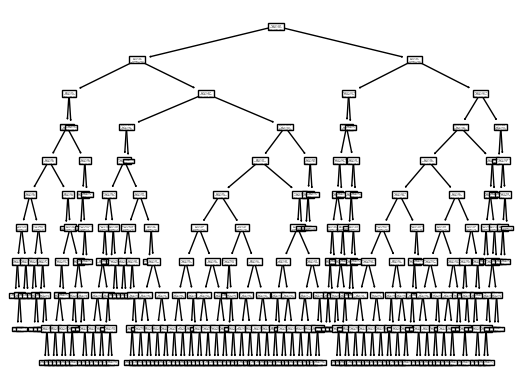

In [29]:
from sklearn import tree
from matplotlib import pyplot as plt

tree.plot_tree(dt)
plt.show()

In [30]:
n_nodes = dt.tree_.node_count
children_left = dt.tree_.children_left
children_right = dt.tree_.children_right
feature = dt.tree_.feature
threshold = dt.tree_.threshold
values = dt.tree_.value
values = np.array([x[0] for x in values])
values

array([[5.961e+03, 1.854e+03],
       [4.695e+03, 1.061e+03],
       [3.800e+02, 4.200e+01],
       [1.390e+02, 4.200e+01],
       [1.280e+02, 2.600e+01],
       [8.600e+01, 7.000e+00],
       [7.000e+01, 3.000e+00],
       [1.800e+01, 2.000e+00],
       [1.500e+01, 0.000e+00],
       [3.000e+00, 2.000e+00],
       [3.000e+00, 0.000e+00],
       [0.000e+00, 2.000e+00],
       [5.200e+01, 1.000e+00],
       [0.000e+00, 1.000e+00],
       [5.200e+01, 0.000e+00],
       [1.600e+01, 4.000e+00],
       [1.300e+01, 1.000e+00],
       [1.000e+00, 0.000e+00],
       [1.200e+01, 1.000e+00],
       [1.200e+01, 0.000e+00],
       [0.000e+00, 1.000e+00],
       [3.000e+00, 3.000e+00],
       [2.000e+00, 0.000e+00],
       [1.000e+00, 3.000e+00],
       [0.000e+00, 2.000e+00],
       [1.000e+00, 1.000e+00],
       [1.000e+00, 0.000e+00],
       [0.000e+00, 1.000e+00],
       [4.200e+01, 1.900e+01],
       [1.600e+01, 0.000e+00],
       [2.600e+01, 1.900e+01],
       [2.200e+01, 9.000e+00],
       [

In [42]:
X = np.asarray(test_X)
X[0]

array([    77,      0, 172744,     15,     10,      2,      0,      0,
            4,      1,      0,      0,     35,     39])

In [41]:
path = "../../FHE-DecisionTree/docs/"
np.savetxt(path + "data.csv", X, delimiter=",")

In [35]:
np.savetxt(path + "children_left.csv", children_left, delimiter=",")
np.savetxt(path + "children_right.csv", children_right, delimiter=",")
np.savetxt(path + "feature.csv", feature, delimiter=",")
np.savetxt(path + "threshold.csv", threshold, delimiter=",")
np.savetxt(path + "values.csv", values, delimiter=",")

## Training and saving modele on preprocessed data

In [52]:
import pickle
df = pd.read_csv('../checkpoint_adult/adult.csv')

label_encoder=preprocessing.LabelEncoder()
df['gender'] = label_encoder.fit_transform(df['gender'])
df['workclass'] = label_encoder.fit_transform(df['workclass'])
df['education'] = label_encoder.fit_transform(df['education'])
df['marital-status'] = label_encoder.fit_transform(df['marital-status'])
df['occupation'] = label_encoder.fit_transform(df['occupation'])
df['relationship'] = label_encoder.fit_transform(df['relationship'])
df['race'] = label_encoder.fit_transform(df['race'])
df['native-country'] = label_encoder.fit_transform(df['native-country'])
df['income'] = label_encoder.fit_transform(df['income'])
aid['gender']=aid['gender'].apply(lambda x: 1 if x == 'Male' else 0)
aid['income']=aid['income'].apply(lambda x: 1 if  x == '>50K'else 0)

train_aid , test_aid =  train_test_split(df,test_size=0.2)
# preprocessing
from sklearn.preprocessing import MinMaxScaler

minmaxscale = MinMaxScaler()
train_aid = pd.DataFrame(minmaxscale.fit_transform(train_aid), columns=train_aid.columns)

Y = train_aid['income']
X = train_aid.drop('income',axis=1)
S = train_aid['gender']



x_train, x_test, y_train, y_test, s_train, s_test = train_test_split(
    X, Y, S, test_size=0.2, random_state=0
)
x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.asarray(x_test), np.asarray(y_test)
s_train, s_test = np.asarray(s_train), np.asarray(s_test)



forest = RandomForestClassifier(max_depth=5)

forest.fit(x_train,y_train)

forest.score(x_test,y_test)

0.8536148432501599

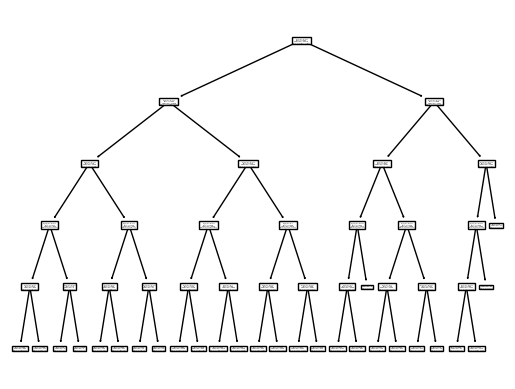

In [55]:
from sklearn import tree
from matplotlib import pyplot as plt

dt = forest.estimators_[1]
tree.plot_tree(dt)
plt.show()

In [59]:
#saving the tree
n_nodes = dt.tree_.node_count
children_left = dt.tree_.children_left
children_right = dt.tree_.children_right
feature = dt.tree_.feature
threshold = dt.tree_.threshold
values = dt.tree_.value
values = np.array([x[0] for x in values])
X = np.asarray(x_test)

path = "../../FHE-DecisionTree/docs/"
np.savetxt(path + "data.csv", X, delimiter=",")

In [60]:
np.savetxt(path + "children_left.csv", children_left, delimiter=",")
np.savetxt(path + "children_right.csv", children_right, delimiter=",")
np.savetxt(path + "feature.csv", feature, delimiter=",")
np.savetxt(path + "threshold.csv", threshold, delimiter=",")
np.savetxt(path + "values.csv", values, delimiter=",")

# Student stats

In [9]:
import sys
sys.path.append("../src")


from aggregator import *
import pickle

class AdultTeacher():
    """
        Define teachers' structure
    """
    def __init__(self, model, metrics):
        self.metrics = metrics
        self.model = model
        
eod_fairs_path = "../checkpoint_adult/EOD/fairs/models.pkl"
eod_unfairs_path = "../checkpoint_adult/EOD/unfairs/models.pkl"
spd_fairs_path = "../checkpoint_adult/SPD/fairs/models.pkl"
spd_unfairs_path = "../checkpoint_adult/SPD/unfairs/models.pkl"

with open(eod_fairs_path, "rb") as f:
    eod_fairs = pickle.load(f)
with open(eod_unfairs_path, "rb") as f:
    eod_unfairs = pickle.load(f)
with open(spd_fairs_path, "rb") as f:
    spd_fairs = pickle.load(f)
with open(spd_unfairs_path, "rb") as f:
    spd_unfairs = pickle.load(f)

In [38]:
data_path = "../checkpoint_adult/st_dataset.pkl"
with open(data_path, "rb") as f:
    dataset = pickle.load(f)

Y = dataset['income']
X = dataset.drop('income',axis=1)
S = dataset['gender']

x_train, x_test, y_train, y_test, s_train, s_test = train_test_split(
        X, Y, S, test_size=0.2, random_state=0
    )
x_train, y_train = np.array(x_train), np.array(y_train)
x_test, y_test = np.asarray(x_test), np.asarray(y_test)
s_train, s_test = np.asarray(s_train), np.asarray(s_test)

# student model
st_model = RandomForestClassifier()

In [45]:
from random import shuffle
conf = ["Normal", "WV2"]
def get_agg(cf):
    if cf == "Normal":
        aggregator = plurality
    elif cf == "WV2":
        aggregator = wv2_aggregator
    
    return aggregator

def fairness_bis(model, x_test, y_test, group_test, forest_model=True, true_y_test=[]):
    yhat = np.round(model.predict(x_test))
    acc = model.score(x_test, y_test)
    
    p_grp_tpr = mean(yhat[(y_test == 1) & (group_test == 1)])
    up_grp_tpr = mean(yhat[(y_test == 1) & (group_test == 0)])
    
    # equality of difference (opportinuty)
    eod = float(format(abs(p_grp_tpr - up_grp_tpr), ".4f"))

    # statistical parity difference
    p_grp = mean(yhat[(group_test == 1)])
    up_grp = mean(yhat[(group_test == 0)])
    spd = float(format(abs(p_grp - up_grp), ".4f"))
    acc_tl = "-"
    if list(true_y_test) != []:
        acc_tl = model.score(x_test, true_y_test)
    
    return {"EOD": eod, "SPD": spd, "ACC": acc, "ACC_TL": acc_tl}

def training_student(nb_teachers, nb_fair_tchrs):
    rec_acc = {}
    for cf in conf:
        rec_acc[cf] = []
    unfairs = spd_unfairs.copy()
    fairs = spd_fairs.copy()

    shuffle(unfairs)
    shuffle(fairs)
    teachers = fairs[:nb_fair_tchrs] + unfairs[:nb_teachers - nb_fair_tchrs]
    update_teachers(teachers)

    spd = []
    for tchrs in teachers:
        spd.append(tchrs.metrics["SPD"])
    set_metrics(spd)

    for cf in conf:
        aggregator = get_agg(cf)
        y_train, _ = aggregator(x_train)
        yhat_test, _ = aggregator(x_test)
        st_model.fit(x_train, y_train)
        st_stats = fairness_bis(st_model, x_test, yhat_test, s_test, true_y_test=y_test)
        rec_acc[cf].append(st_stats["ACC"])
        rec_acc[cf].append(st_stats["ACC_TL"])
    return rec_acc

In [58]:
acc_stats = training_student(30, randint(1,30))

In [59]:
acc_stats

{'Normal': [0.9718526100307062, 0.8474923234390993],
 'WV2': [0.962128966223132, 0.845957011258956]}

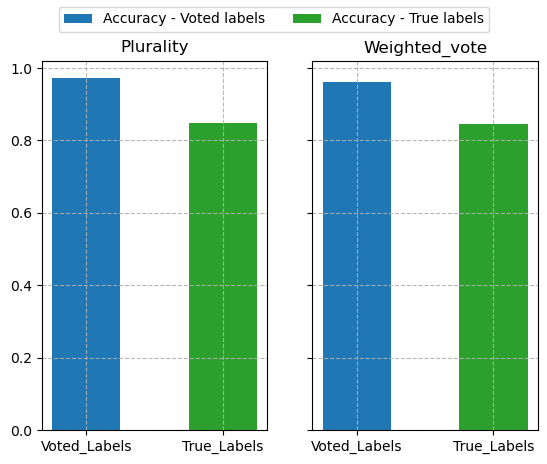

In [65]:
import matplotlib.pyplot as plt
colors = plt.rcParams["axes.prop_cycle"].by_key()['color']

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
#axes[1][3].set_visible(False)
ax1.set_title("Plurality")
ax2.set_title("Weighted_vote")
l = 0
i = 0
b_width = 0.5
x_axes = [1, 2]
for cf in conf:
    if l < 1:
        ax.set_title(lab)
    else:
        ax.set_xlabel(lab)
    acc, acc_tl = acc_stats[cf]
    if cf == "Normal":
        ax1.bar([x_axes[0]], [acc], width = b_width, color = colors[0], label="Accuracy - Voted labels")
        ax1.bar([x_axes[1]], [acc_tl], width = b_width, color = colors[2], label="Accuracy - True labels")
    else:
        ax2.bar([x_axes[0]], [acc], width = b_width, color = colors[0])
        ax2.bar([x_axes[1]], [acc_tl], width = b_width, color = colors[2])

ax1.set_xticks([1, 2], ["Voted_Labels", "True_Labels"])
ax1.grid(True, linestyle='--', alpha=0.9)


ax2.set_xticks([1, 2], ["Voted_Labels", "True_Labels"])
ax2.grid(True, linestyle='--', alpha=0.9)
fig.legend(loc="outside upper center", ncol=4)
plt.savefig("../img/st_stats_adult.png")
plt.show()